In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import re

from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

rc('text', usetex=True)
fontsize = 26
params = {
    'font.family': 'Times New Roman ',
#     'font.weight': 150,
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize-2,
    'xtick.labelsize': fontsize-2,
    'ytick.labelsize': fontsize-2,
    'legend.fontsize': fontsize-5,
}
plt.rcParams.update(params)

In [16]:
fpath = '/home/ubuntu/code/Spectral-GNN-Benchmark/log/deg_normg-fb.csv'
t = pd.read_csv(fpath, engine='python')

t['s_test'] = t.apply(lambda row: row[row['metric'] + '_test'], axis=1)
t['s_high'] = t.apply(lambda row: row[row['metric'] + '_high'], axis=1)
t['s_low'] = t.apply(lambda row: row[row['metric'] + '_low'], axis=1)
# t['normg'] = t
t

,seed,normg,data,metric,model,conv,epoch_best,epoch_learn,time_learn,mem_ram_train,...,s_f1i_high,s_acc_low,s_ap_low,s_auroc_low,s_f1i_low,deg_high,deg_low,s_test,s_high,s_low
0,60,0.0,cora,s_f1i,MLP,Identity-ones,116,500,1.9314,1.186,...,76.364,73.035,79.446,94.522,78.422,110,431,78.004,76.364,78.422
1,61,0.0,cora,s_f1i,MLP,Identity-ones,40,500,1.1934,1.260,...,75.000,68.126,76.626,91.841,71.854,104,437,72.458,75.000,71.854
2,62,0.0,cora,s_f1i,MLP,Identity-ones,123,500,1.1943,1.260,...,78.641,72.769,79.397,93.231,76.484,103,438,76.895,78.641,76.484
3,60,0.0,cora,s_f1i,DecoupledFixed,AdjiConv-ones,64,500,9.1036,1.231,...,86.364,84.234,90.254,97.374,86.079,110,431,86.137,86.364,86.079
4,61,0.0,cora,s_f1i,DecoupledFixed,AdjiConv-ones,83,500,8.1417,1.288,...,86.538,84.340,89.547,97.133,85.584,104,437,85.767,86.538,85.584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,61,0.0,pubmed,s_f1i,DecoupledVar,ClenshawConv,246,500,13.2439,1.398,...,84.472,78.188,84.652,91.469,79.853,805,3137,80.797,84.472,79.853
3599,62,0.0,pubmed,s_f1i,DecoupledVar,ClenshawConv,253,500,13.2349,1.400,...,85.457,78.034,83.295,91.567,80.695,777,3165,81.634,85.457,80.695
3600,60,0.0,pubmed,s_f1i,DecoupledVar,ChebIIConv,111,500,20.8929,1.231,...,88.061,90.133,95.545,97.523,90.439,846,3096,89.929,88.061,90.439
3601,61,0.0,pubmed,s_f1i,DecoupledVar,ChebIIConv,116,500,20.1877,1.368,...,84.099,81.973,88.822,93.501,83.009,805,3137,83.232,84.099,83.009


In [17]:
dlst = ["cora", "citeseer", "chameleon_filtered", "squirrel_filtered", "actor", "roman_empire", ]
id_cols = ["seed", 'normg', 'data', 'model', 'conv',]
m_cols = ['deg_high', 'deg_low', 's_test', 's_high', 's_low', 's_auroc_high', 's_auroc_low']
conv_repr = {
    'MLP': {'Identity-ones': 'Identity',},
    'DecoupledFixed': {
        'AdjiConv-ones':    'Linear',
        'AdjConv-impulse':  'Impulse',
        'AdjConv-mono':     'Monomial',
        'AdjConv-appr':     'PPR',
        'AdjConv-hk':       'HK',
        'AdjConv-gaussian': 'Gaussian',},
    'DecoupledVar': {
        'AdjiConv':         'Var-Linear',
        'AdjConv':          'Var-Monomial',
        'HornerConv':       'Horner',
        'ChebConv':         'Chebyshev',
        'ClenshawConv':     'Clenshaw',
        'ChebIIConv':       'ChebInterp',
        'BernConv':         'Bernstein',
        'LegendreConv':     'Legendre',
        'JacobiConv':       'Jacobi',
        'FavardConv':       'Favard',
        'OptBasisConv':     'OptBasis',},
    # 'AdaGNN': {'LapiConv':  'AdaGNN',},
    #     'OptBasisConv':     'OptBasisGNN',},
    # 'ACMGNN': {'ACMConv-2.0-low-high-id':  'ACMGNN',}
        # 'ACMConv-1.0-low-high':     'FBGNNI',
        # 'ACMConv-2.0-low-high':     'FBGNNII',
        # 'ACMConv-1.0-low-high-id':  'ACMGNNI',
        # 'ACMConv-2.0-low-high-id':  'ACMGNNII',},
    # 'DecoupledFixedCompose': {
    #     'AdjiConv,AdjiConv-ones,ones': 'FAGNN',
    #     'Adji2Conv,Adji2Conv-gaussian,gaussian': 'G$^2$CN',
    #     'AdjDiffConv,AdjDiffConv-appr,appr': 'GNN-LF/HF',},
    # 'DecoupledVarCompose': {
    #     'AdjConv,ChebConv,BernConv': 'FiGURe',}
}

def reverse_name(name):
    for k, m in conv_repr.items():
        for c, n in m.items():
            if n == name:
                return k, c
    return None, None

flst = []
for m in conv_repr.values():
    for c, name in m.items():
        flst.append(name)

def get_df(t):
    tt = t[t['data'].isin(dlst)][id_cols+m_cols].sort_values(by=['data', 'normg', 'model', 'conv', 'seed'])
    # print(tt.sort_index(ascending=False).groupby(['data', 'model', 'conv']).filter(lambda x: len(x) > 10))
    df = tt.groupby(['data', 'normg', 'model', 'conv'])[m_cols].agg(['mean', 'std'])
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.reset_index(inplace=True)

    df['name'] = df.apply(lambda row: conv_repr[row['model']][row['conv']] if (row['model'] in conv_repr) and (row['conv'] in conv_repr[row['model']]) else None, axis=1)
    df.dropna(subset=['name'], inplace=True)
    df.drop(columns=['model', 'conv'], inplace=True)
    df = df[['data', 'normg', 'name'] + df.columns.tolist()[2:-1]]
    return df

df = get_df(t)
df

,data,normg,name,deg_high_mean,deg_high_std,deg_low_mean,deg_low_std,s_test_mean,s_test_std,s_high_mean,s_high_std,s_low_mean,s_low_std,s_auroc_high_mean,s_auroc_high_std,s_auroc_low_mean,s_auroc_low_std
0,actor,0.0,PPR,314.666667,13.576941,1205.333333,13.576941,34.978000,0.385786,36.856667,2.101490,34.482667,1.023918,66.695667,0.801015,66.178333,0.861067
1,actor,0.0,Gaussian,314.666667,13.576941,1205.333333,13.576941,36.842333,0.687001,38.469333,0.801300,36.416000,0.772050,71.967667,1.291302,70.426333,0.273160
2,actor,0.0,HK,314.666667,13.576941,1205.333333,13.576941,36.754333,0.418002,36.959000,1.369422,36.693333,0.725674,71.800667,1.348079,70.049000,1.300500
3,actor,0.0,Impulse,314.666667,13.576941,1205.333333,13.576941,27.280667,0.422817,28.469000,1.162046,26.963333,0.308468,58.490000,1.371754,55.620000,0.653149
4,actor,0.0,Monomial,314.666667,13.576941,1205.333333,13.576941,34.342333,0.696400,35.344000,2.222566,34.070333,1.310410,66.094000,2.150358,65.365667,0.243525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,squirrel_filtered,1.0,Horner,91.666667,2.516611,352.333333,2.516611,36.336333,2.973850,29.423000,6.190811,38.129000,2.140393,53.589333,2.022361,54.357000,2.539980
1184,squirrel_filtered,1.0,Jacobi,91.666667,2.516611,352.333333,2.516611,34.759667,1.375864,25.813000,0.798423,37.090667,1.584332,51.530333,10.613217,49.819667,10.690457
1185,squirrel_filtered,1.0,Legendre,91.666667,2.516611,352.333333,2.516611,35.585667,2.477500,26.193000,7.627087,38.039000,1.705564,58.556333,6.763853,59.149000,8.802727
1186,squirrel_filtered,1.0,OptBasis,91.666667,2.516611,352.333333,2.516611,30.706000,2.816249,25.000667,5.991179,32.177333,2.311776,51.687000,4.700378,49.606667,3.396269


## Line: normg

In [51]:
import colorsys
def lighten_color(color, amount=1.5):
    c = colorsys.rgb_to_hls(*color[:3])
    c = colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    return np.array(c + (1,))

issave = False
cm20 = plt.cm.tab20(np.arange(0, 20))
cm2 = plt.cm.Set2(np.arange(0, 8))
cm3 = plt.cm.Set3(np.arange(0, 12))

cm2_dark = np.asarray([lighten_color(c, 1.5) for c in cm2])

In [5]:
argdct = {
    'Identity':     {'color': cm3[4], 'ls': ':'},
    'Linear':       {'color': cm3[0], 'ls': '-',  'marker': '*'},
    'Monomial':     {'color': cm3[2], 'ls': '-',  'marker': 'P'},
    'PPR':          {'color': cm3[3], 'ls': '-',  'marker': 'X'},
    # 'HK':           {'color': cm3[4], 'ls': '-',  'marker': 'v'},
    'Var-Monomial': {'color': cm3[5], 'ls': '--', 'marker': '^'},
    'Chebyshev':    {'color': cm3[6], 'ls': '--', 'marker': 'o'},
    # 'Bernstein':    {'color': cm3[6], 'ls': '--', 'marker': 's'},
    # 'Legendre':     {'color': cm3[7], 'ls': '--', 'marker': 'D'},
    'Jacobi':       {'color': cm3[8], 'ls': '--', 'marker': 's'},
    # 'Favard':       {'color': cm3[9], 'ls': '--', 'marker': '<'},
    'OptBasis':     {'color': cm3[7], 'ls': '--', 'marker': '>'},
}

# list(enumerate(flst))

In [13]:
def plot_acchop(data, ylim=None, loc=2):
    fig, ax = plt.subplots(1, 1, figsize=(13, 6), dpi=(150 if issave else 72))
    args = {'markersize': 16, 'linewidth': 4}
    for k, argk in argdct.items():
        dfk = df[(df['data']==data) & (df['name']==k)]
        s_high, s_low = dfk['s_high_mean'], dfk['s_low_mean']
        if k == 'Identity':
            s_high = np.array([s_high.mean()]*len(s_high))
            s_low = np.array([s_low.mean()]*len(s_low))
        ax.plot(dfk['normg'], s_high-s_low, label=k,
                **argk, **args)

    if ylim is not None:
        ax.set(ylim=ylim)
    ax.set(xlim=[-0.02, 1.02],
        xlabel='Graph Norm $\\rho$', ylabel='High - Low (\\%)')
    ax.set_xticks(dfk['normg'])
    ax.set_xticklabels(dfk['normg'])

    ax.grid(True, which='both', axis='y', ls='--')
    ax.grid(True, axis='x', ls='--')
    ax.legend(ncol=4, loc=loc,
             columnspacing=0.5, handlelength=1.4, handletextpad=0.3)
    return fig, ax

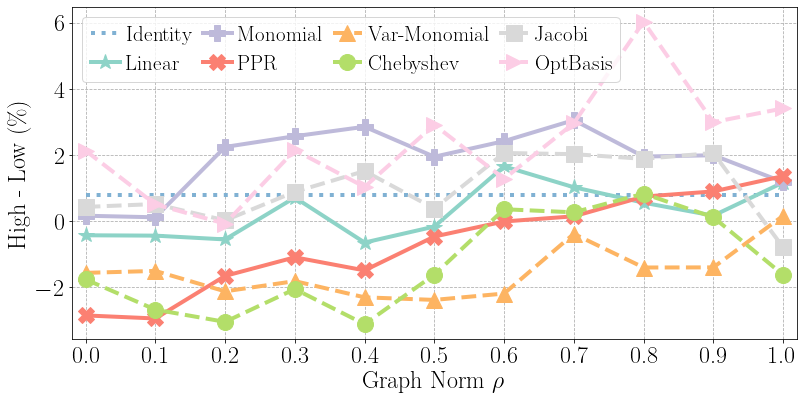

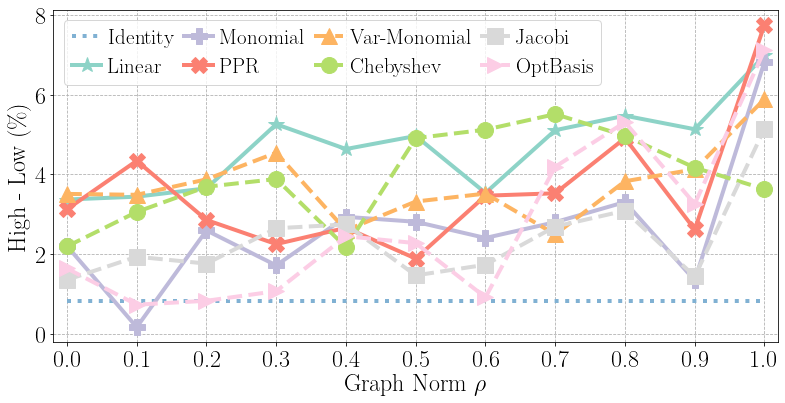

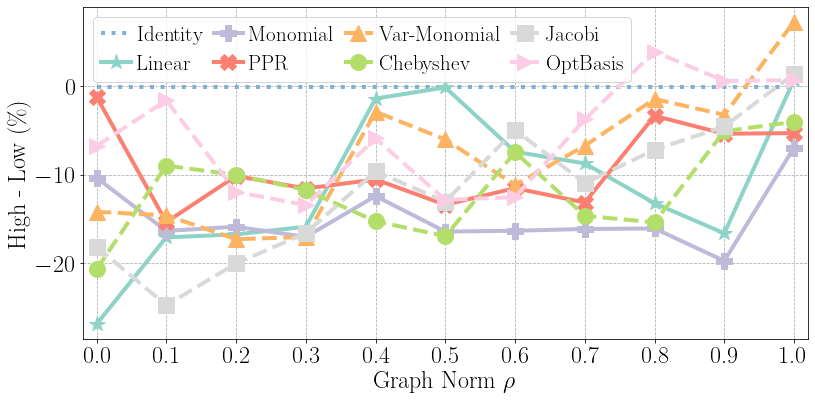

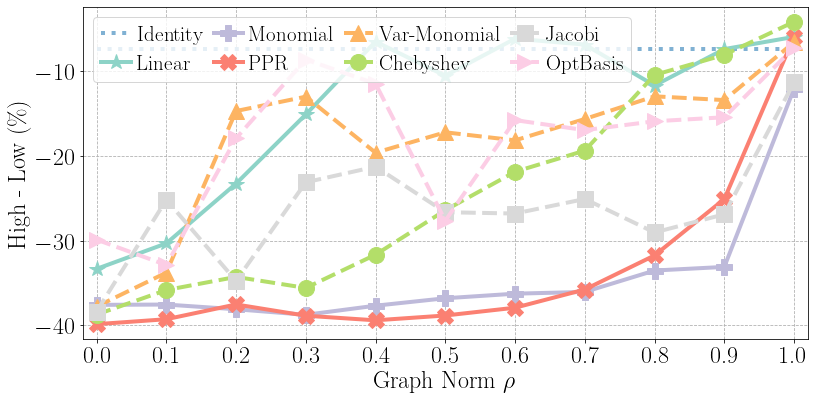

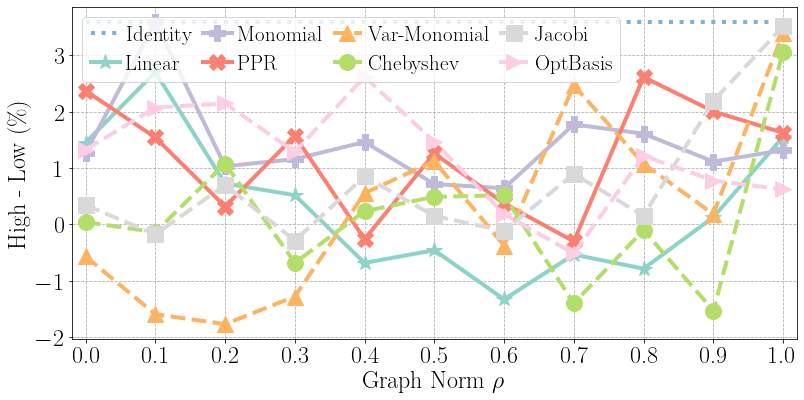

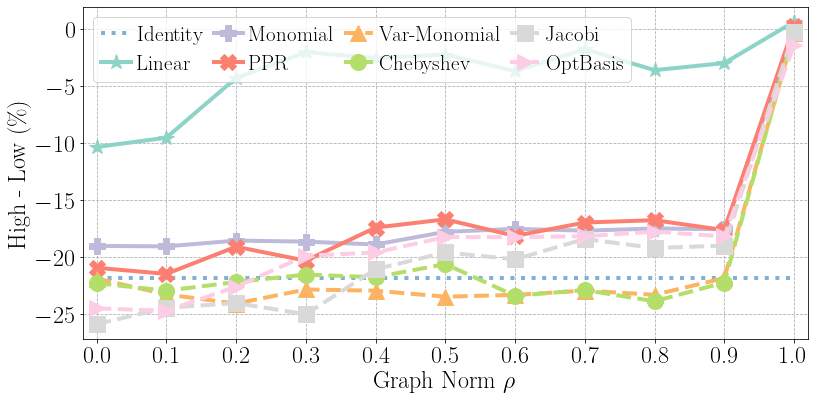

In [15]:
for d in dlst:
    fig, ax = plot_acchop(d)
    if issave:
        fig.savefig(f'./figs/deg_ng_{d}.pdf', bbox_inches='tight')